In [1]:
# imports general modules, runs ipython magic commands
# change path in this notebook to point to repo locally
# n.b. sometimes need to run this cell twice to init the plotting paramters
%run ../setup_notebook.ipynb

In [103]:
# general imports
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import colors as mcolors
import seaborn as sns
from subsets_analysis import Subsets
from run_functions import filter_trials
import time

In [3]:
# notebook specific imports
import pickle
import utils_funcs as utils
import re

In [4]:
# global plotting params
sns.set()
sns.set_style('white')
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'lines.markersize': 15}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)


In [5]:
mice_dicts = [
    
{'mouse_id': 'J048', 'run_numbers': [27,28,29,30,32], 'runs': []},
{'mouse_id': 'RL048', 'run_numbers': [23, 24, 25, 28, 29], 'runs': []},
{'mouse_id': 'J063', 'run_numbers': [8,9,10,11,12,13,14], 'runs': []},
{'mouse_id': 'J064', 'run_numbers': [10,11,12,13,14,15], 'runs': []},
{'mouse_id': 'J065', 'run_numbers': [10,11,12,13,14,15], 'runs': []},
    
]

In [6]:
for mouse_dict in mice_dicts:
    for run_number in mouse_dict['run_numbers']:
        
        pkl_path = os.path.join(path_to_vape, 'run_pkls', mouse_dict['mouse_id'], 
                                'run{}.pkl'.format(run_number))

        with open(pkl_path, 'rb') as f:
            run = pickle.load(f)
            
        mouse_dict['runs'].append(run)
                

In [7]:
def trial_outcomes(outcome):

    go_outcome = []
    nogo_outcome = []

    for t in outcome:
        if t == 'hit':
            go_outcome.append(True)
        elif t == 'miss':
            go_outcome.append(False)
        elif t =='cr':
            nogo_outcome.append(False)
        elif t == 'fp':
            nogo_outcome.append(True)

    go_outcome = np.array(go_outcome)
    nogo_outcome = np.array(nogo_outcome)
    
    return go_outcome, nogo_outcome

In [15]:
def get_subset_dprime(run):
    
    ''' get the d-prime for each subset in a run.
        Returns nan if < 10 trials of a subset in a session
        '''

    go_outcome, nogo_outcome = trial_outcomes(run.outcome)
    trial_subsets = []
    
    for i, info in enumerate(run.trial_info):
        if 'Nogo Trial' in info:
            continue
        elif 'all_cells_stimulated' in info:
            trial_subsets.append(150)
        elif 'Subset cells experiment' in info:
            trial_subset = int(re.search('(?<=stimulating )(.*)(?= cells)', info).group(0))
            trial_subsets.append(trial_subset)

    trial_subsets = np.array(trial_subsets)
    subsets = np.sort(np.unique(trial_subsets))
        
    fp_rate = sum(nogo_outcome) / len(nogo_outcome)
    subset_outcome = []
        
    assert len(go_outcome) == len(trial_subsets), '{} {}'.format(len(trial_subsets), len(go_outcome))
    for sub in subsets:
        subset_idx = np.where(trial_subsets == sub)[0]
        if len(subset_idx) < 10:
            subset_outcome.append(np.nan)
        else:
            subset_outcome.append(sum(go_outcome[subset_idx]) / len(subset_idx))

    subsets_dprime = [utils.d_prime(outcome, fp_rate) for outcome in subset_outcome]
    #subsets_dprime = subset_outcome
    return subsets, subsets_dprime, fp_rate
    

In [16]:
def get_psychometric(runs):
    
    across_sessions = []
    fp_rates = []

    for run in runs:
        
        #filter_trials(run, plot=True)
        
        global subsets  # hackkkkkkk
        subsets, subsets_dprime, fp_rate = get_subset_dprime(run)

        across_sessions.append(subsets_dprime)
        fp_rates.append(fp_rate)

    across_sessions = np.array(across_sessions)   
    meaned = np.nanmean(across_sessions, 0)
    
    # Currently returning mean of fp rate to avoid
    # session speicific info in dict
    return meaned, np.mean(fp_rates)

In [17]:
for mouse_dict in mice_dicts:
    dprimes, fp_rate = get_psychometric(mouse_dict['runs'])
    mouse_dict['dprimes'] = dprimes
    mouse_dict['fp_rate'] = fp_rate

across_mice = np.array([mouse_dict['dprimes'] for mouse_dict in mice_dicts])

In [18]:
mice_dicts[0]

{'mouse_id': 'J048',
 'run_numbers': [27, 28, 29, 30, 32],
 'runs': [<opto_stim_import2.BlimpImport at 0x7f26f1f14910>,
 'dprimes': array([0.32599388, 0.45650821, 0.53726837, 0.30156373, 0.93472013,
        1.00865738, 1.08557284]),
 'fp_rate': 0.3699193336695924}

(0, 1.6)

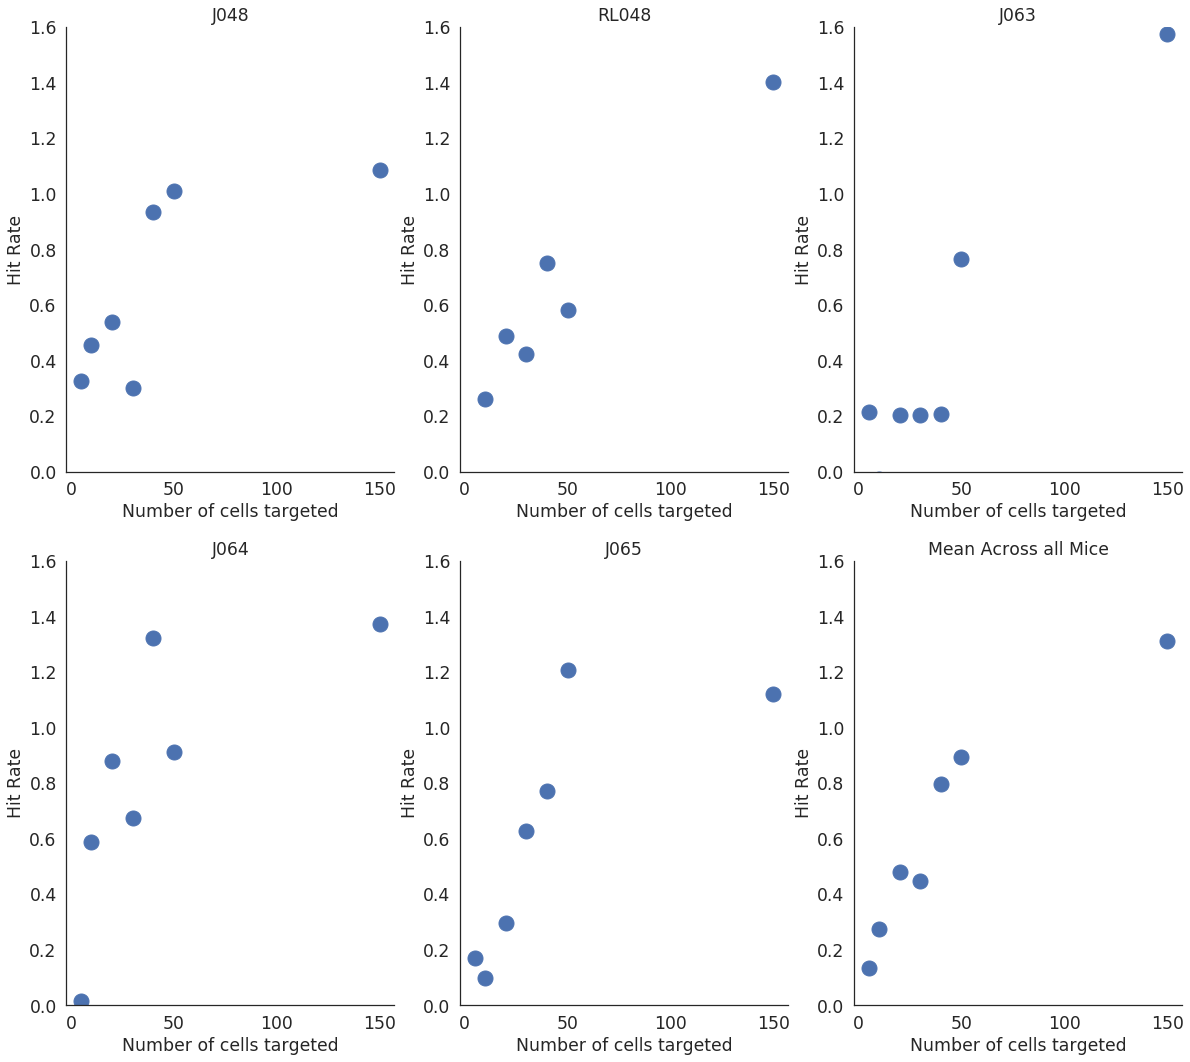

In [21]:
plt.figure(figsize=(20,18))

plot_idx = 0
for mouse_dict in mice_dicts:
    plot_idx += 1
    plt.subplot(2, 3, plot_idx)
    plt.plot(subsets, mouse_dict['dprimes'], '.', markersize=30)
    plt.xlabel('Number of cells targeted')
    plt.ylabel('Hit Rate')
    plt.title(mouse_dict['mouse_id'])
    plt.ylim((0,1.6))
    
plt.subplot(2,3,6)
plt.plot(subsets, np.mean(across_mice, 0), '.', markersize=30)
plt.xlabel('Number of cells targeted')
plt.ylabel('Hit Rate')
plt.title('Mean Across all Mice')
plt.ylim((0,1.6))


In [77]:
run = mice_dicts[0]['runs'][1]
hit_rate = len(np.where(run.outcome=='hit')[0]) / num_go 
fp_rate = len(np.where(run.outcome=='fp')[0]) / num_nogo
session_dprime = utils.d_prime(hit_rate, fp_rate)
session_dprime

0.8770490727654598

In [159]:
#licks are binned and normalised to trial start time (5ms before LED pulse)
binned_licks = np.array(run.binned_licks)

trial_type = np.array(run.trial_type)

sorted_licks = binned_licks[trial_idxs]
trial_subsets = Subsets(run).trial_subsets
trial_idxs = trial_subsets.argsort()
sorted_subsets = trial_subsets[trial_idxs]

num_trials = len(run.outcome)
num_go = len(np.where(trial_type=='go')[0])
num_nogo = len(np.where(trial_type=='nogo')[0])

In [160]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]
#sorted_names

start_color = 0

color_map = {}

for i, sub in enumerate(np.unique(trial_subsets)):
    color_map[sub] = sorted_names[start_color+i*20]

subset_colors = [color_map[i] for i in trial_subsets[trial_idxs]]






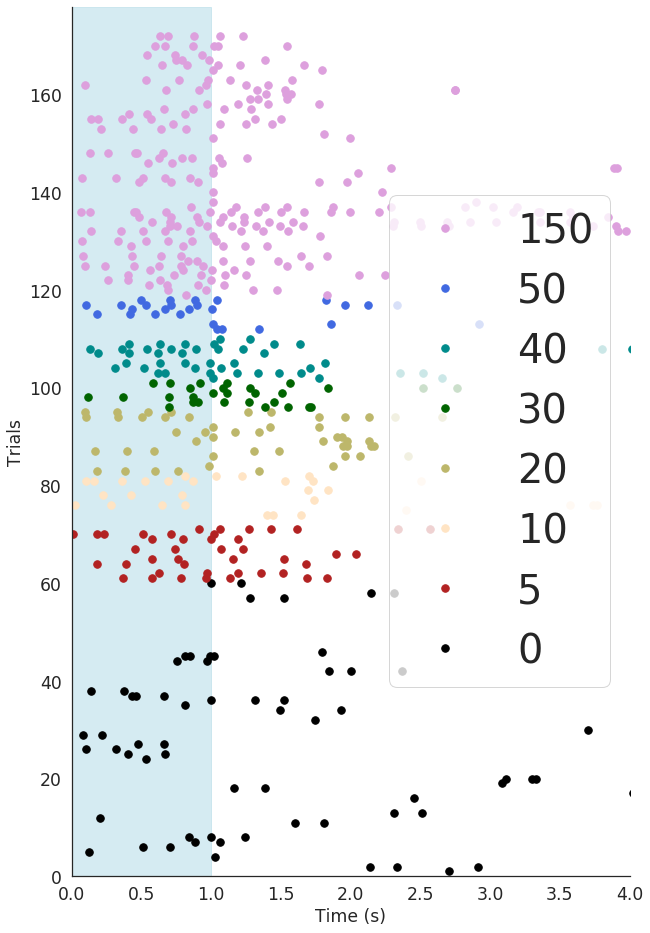

In [175]:
plt.figure(figsize=[10,16])

for i, b in enumerate(sorted_licks):
    
    color=subset_colors[i]
    y_axis = np.ones(len(b)) + i
    
    if sorted_subsets[i] != sorted_subsets[i-1]:
        label = sorted_subsets[i]
    else:
        label = None
    plt.plot(b/1000, y_axis,'.', c=color, label=label)
    
plt.fill_between([0,1], 0, num_trials+5, color='lightblue', alpha=0.5)
plt.xlim((0,4))
sns.despine()
plt.xlabel('Time (s)')
plt.ylabel('Trials')
plt.ylim((0,num_trials+5))
plt.legend()
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='right', fontsize=40)
#plt.savefig(os.path.join(figure_path, 'lick_raster.png'))
#plt.savefig(os.path.join(figure_path, 'lick_raster.svg'))

173
55
173
1.0
0.0


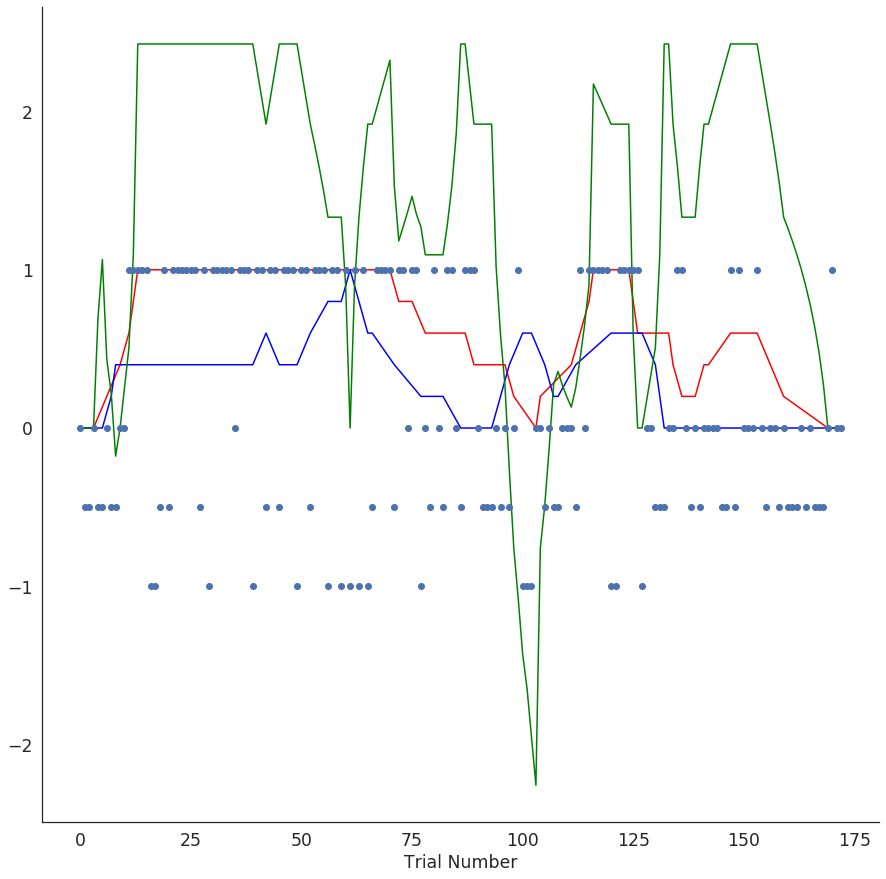

In [297]:
filtered = filter_trials(run, window_size=5, plot=True)

In [295]:
filtered

array([ 12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93, 117,
       118, 119, 120, 121, 122, 123, 124, 132, 133, 134, 135, 136, 137,
       138, 139, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 165, 166, 167, 168, 169, 170, 171, 172])

In [212]:
subsets = Subsets(run)
np.where((subsets.trial_subsets!=150) & (subsets.trial_subsets!=0))[0]

array([  0,  10,  14,  21,  22,  25,  26,  28,  30,  32,  34,  35,  36,
        38,  41,  48,  50,  51,  53,  55,  58,  60,  62,  68,  69,  73,
        74,  76,  83,  84,  85,  88,  90,  94,  99, 106, 109, 110, 114,
       118, 119, 122, 123, 128, 129, 135, 137, 143, 144, 150, 151, 152,
       154, 157, 163, 165, 170, 171])

In [183]:
run.trial_type

['go',
 'nogo',
 'nogo',
 'go',
 'nogo',
 'nogo',
 'go',
 'nogo',
 'nogo',
 'go',
 'go',
 'go',
 'go',
 'go',
 'go',
 'go',
 'nogo',
 'nogo',
 'nogo',
 'go',
 'nogo',
 'go',
 'go',
 'go',
 'go',
 'go',
 'go',
 'nogo',
 'go',
 'nogo',
 'go',
 'go',
 'go',
 'go',
 'go',
 'go',
 'go',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'nogo',
 'go',
 'nogo',
 'go',
 'nogo',
 'go',
 'nogo',
 'nogo',
 'go',
 'go',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'go',
 'go',
 'go',
 'nogo',
 'go',
 'nogo',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'go',
 'go',
 'nogo',
 'nogo',
 'nogo',
 'go',
 'nogo',
 'go',
 'nogo',
 'go',
 'go',
 'nogo',
 'nogo',
 'nogo',
 'go',
 'go',
 'nogo',
 'go',
 'nogo',
 'nogo',
 'go',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'go',
 'go',
 'go',
 'go',
 'go',
 'nogo',
 'nogo',
 'go',
 'go',
 'go',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'no

In [184]:
run.trial_type



['go',
 'nogo',
 'nogo',
 'go',
 'nogo',
 'nogo',
 'go',
 'nogo',
 'nogo',
 'go',
 'go',
 'go',
 'go',
 'go',
 'go',
 'go',
 'nogo',
 'nogo',
 'nogo',
 'go',
 'nogo',
 'go',
 'go',
 'go',
 'go',
 'go',
 'go',
 'nogo',
 'go',
 'nogo',
 'go',
 'go',
 'go',
 'go',
 'go',
 'go',
 'go',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'nogo',
 'go',
 'nogo',
 'go',
 'nogo',
 'go',
 'nogo',
 'nogo',
 'go',
 'go',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'go',
 'go',
 'go',
 'nogo',
 'go',
 'nogo',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'go',
 'go',
 'nogo',
 'nogo',
 'nogo',
 'go',
 'nogo',
 'go',
 'nogo',
 'go',
 'go',
 'nogo',
 'nogo',
 'nogo',
 'go',
 'go',
 'nogo',
 'go',
 'nogo',
 'nogo',
 'go',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'go',
 'go',
 'go',
 'go',
 'go',
 'nogo',
 'nogo',
 'go',
 'go',
 'go',
 'go',
 'go',
 'nogo',
 'go',
 'go',
 'no

## Not sure what the purpose of this code is

In [ ]:
def subsets_hit_fp(run):
    
    ''' Hacky function code copied from above to get out
        dprimes calculated across all sessions
        '''
    
    go_outcome, nogo_outcome = trial_outcomes(run.outcome)
    
    trial_subsets = []

    for i, info in enumerate(run.trial_info):
        if 'Nogo Trial' in info:
            continue
        elif 'all_cells_stimulated' in info:
            trial_subsets.append(150)
        elif 'Subset cells experiment' in info:
            trial_subset = int(re.search('(?<=stimulating )(.*)(?= cells)', info).group(0))
            trial_subsets.append(trial_subset)

    trial_subsets = np.array(trial_subsets)
    global subsets # lol
    subsets = np.sort(np.unique(trial_subsets))
    assert len(trial_subsets) == len(go_outcome), 'dsdsd {} {}'.format(len(trial_subsets), len(go_outcome))
    
    subby = [] # list of lists
    
    for sub in subsets:
        subset_idx = np.where(trial_subsets == sub)[0]
        subby.append(go_outcome[subset_idx])
        
        
    fp_rate = sum(nogo_outcome) / len(nogo_outcome)
    
    return subby, fp_rate
        

In [ ]:
fp_rates = []


for i, run_number in enumerate(run_numbers):
    pkl_path = os.path.join(path_to_vape, 'run_pkls', mouse_id, 'run{}.pkl'.format(run_number))
    print(i)
    with open(pkl_path, 'rb') as f:
        run = pickle.load(f)
        
    subby, fp_rate = subsets_hit_fp(run)
    fp_rates.append(fp_rate)
    
    if i == 0:    
        all_subbys = subby
    
    else:
        for i, lst in enumerate(all_subbys):   
            all_subbys[i] = np.append(lst, subby[i])

In [ ]:
# change this need to sum and divide by len across all sessions
fp_rate = np.mean(fp_rates)
fp_rate

In [ ]:
hit_rates = []

dprimes = []

for i,sub in enumerate(all_subbys):
    hit_rate = sum(sub) / len(sub)
    print(len(sub))
    dprimes.append(utils.d_prime(hit_rate, fp_rate))

In [ ]:
plt.plot(subsets, dprimes, '.')
plt.xlabel('Number of Cells Targeted')
plt.ylabel('d-prime')
plt.title('{} number of sessions = {}'.format(mouse_id, len(fp_rates)))
plt.ylim((-0.1,1.5))